In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import tensorflow as tf
import pandas as pd
import json
import os

from core.data  import pretraining_records
from core.astromer import get_ASTROMER, train

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
exp_path = './runs/machito_0'

In [4]:
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 50,
 'msk_frac': 0.5,
 'rnd_frac': 0.2,
 'same_frac': 0.2,
 'data': './data/records/machito/',
 'p': './runs/machito_0',
 'batch_size': 256,
 'epochs': 10000,
 'patience': 200,
 'layers': 2,
 'heads': 4,
 'head_dim': 256,
 'dff': 128,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001,
 'use_leak': False,
 'no_train': False,
 'no_shuffle': False,
 'exp_date': '2021-09-02 15:07:15'}

In [5]:
dataset_path = './data/records/machito'
test_batches = pretraining_records(os.path.join(dataset_path, 'test'), 
                            256, 
                            max_obs=conf['max_obs'],
                            no_shuffle=True,
                            msk_frac=conf['msk_frac'],
                            rnd_frac=conf['rnd_frac'],
                            same_frac=conf['same_frac'])

df_objects = pd.read_csv(os.path.join(dataset_path, 'objects.csv'))
class_names = df_objects['label'].values
df_objects

[INFO] No shuffling


,label,size
0,UNK,375696


In [6]:
# from core.data  import from_generator
# test_batches = from_generator(conf['max_obs'], 100, 16)

In [7]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        use_leak=conf['use_leak'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

In [8]:
# tf.keras.utils.plot_model(astromer, show_shapes=True)

In [9]:
weights_path = '{}/weights'.format(conf['p'])
astromer.load_weights(weights_path)

In [10]:
from core.astromer import predict

In [11]:
%%time
result = predict(astromer, test_batches, conf)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['lcid', 'label', 'output', 'mask_out', 'mean', 'obserr'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 201it [00:17, 11.63it/s]


KeyboardInterrupt: 

In [12]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

In [13]:
%%time
r2_masked = []
rmse_masked = []
for yt, yp, m in zip(result['x_true'], result['x_pred'], result['mask']):
    
    y_true_mask = tf.boolean_mask(yt[:, None], m)
    y_pred_mask = tf.boolean_mask(yp, m)

    r2_value = r2_score(y_true_mask, y_pred_mask)
    rmse = mean_squared_error(y_true_mask, y_pred_mask, squared=False)
    r2_masked.append(r2_value)
    rmse_masked.append(rmse)

NameError: name 'result' is not defined

In [14]:
print('r2: {}\nmse: {} - {}'.format(np.mean(r2_masked), result['mse'], np.mean(rmse_masked)))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'result' is not defined

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


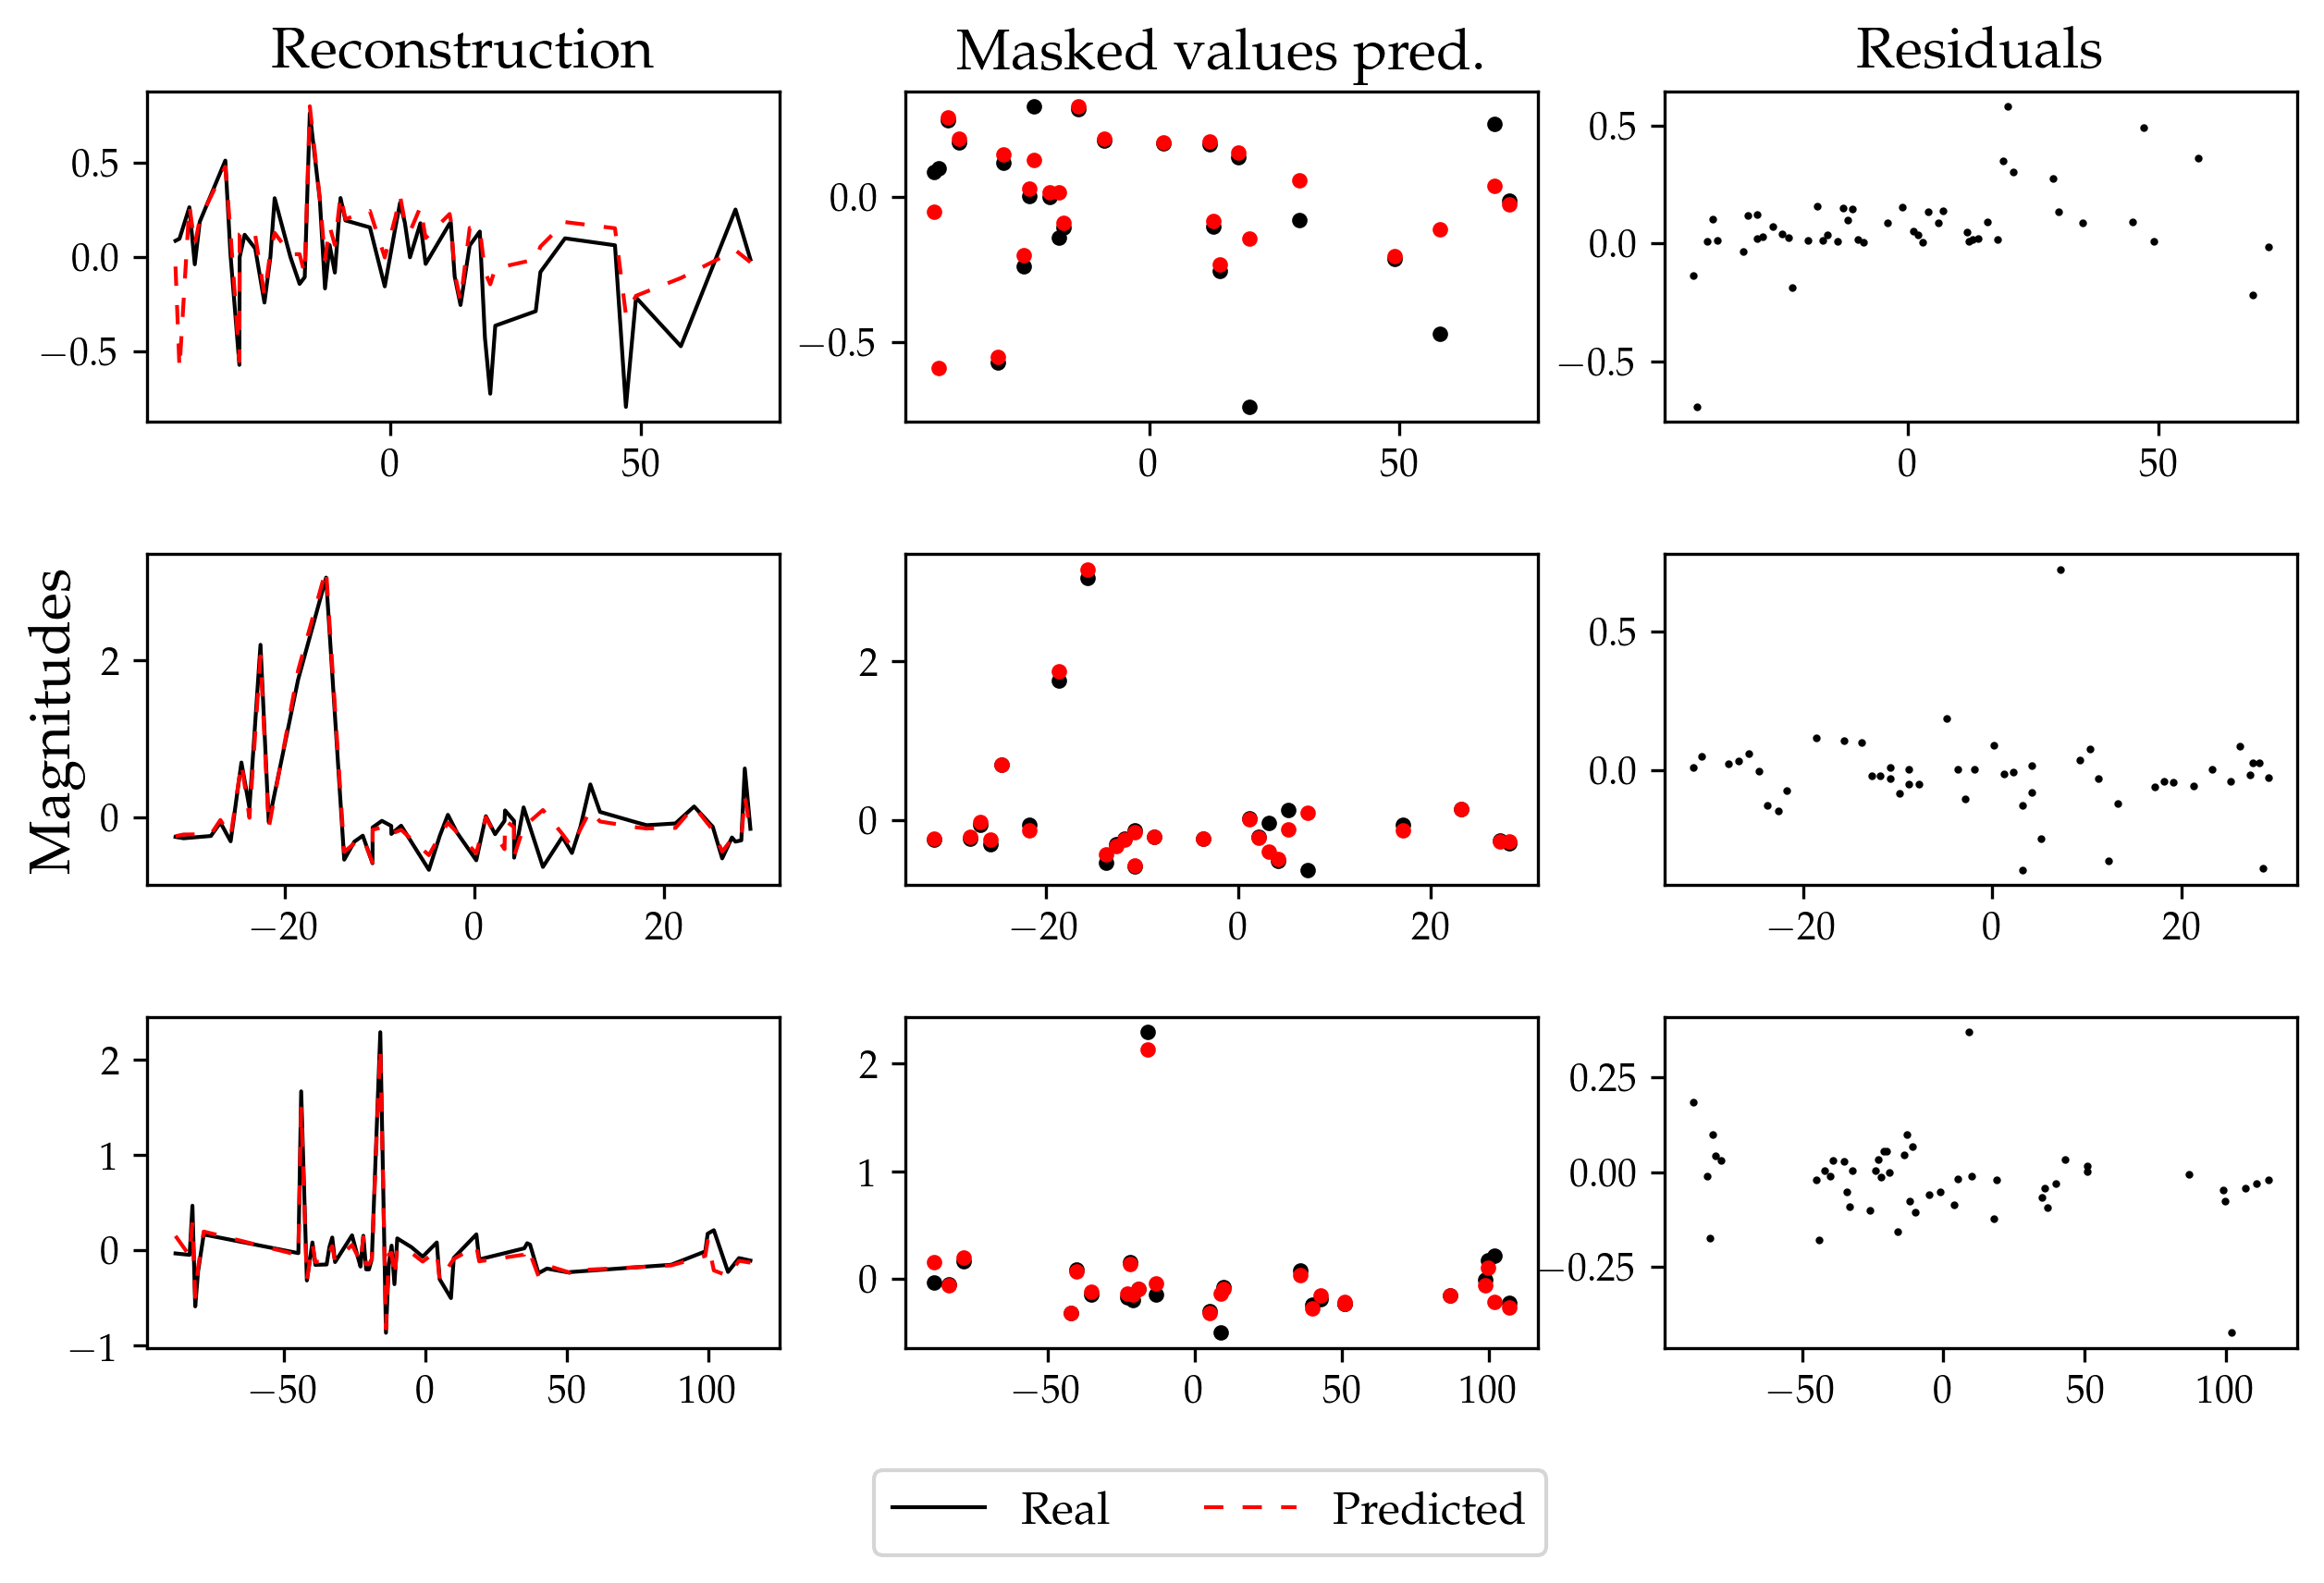

In [17]:
N = 3
fig, axes = plt.subplots(N, 3, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=False)

obs = conf['max_obs']//2

for i in range(N):

    times = result['time'][i]
    serie_pred = result['x_pred'][i]
    serie_true = result['x_true'][i]
    
    axes[i][0].plot(times, serie_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times, serie_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    
    if i == 1:
        axes[i][0].set_ylabel('Magnitudes', fontsize=15)
    
    
    true_mask = tf.boolean_mask(result['x_true'][i], result['mask'][i])
    pred_mask = tf.boolean_mask(result['x_pred'][i], result['mask'][i])
    time_mask = tf.boolean_mask(times, result['mask'][i])

    axes[i][1].plot(time_mask, true_mask, marker='.',linewidth=1, linestyle='', color='k', label='Real')
    axes[i][1].plot(time_mask, pred_mask, marker='.',linewidth=1, linestyle='', color='red', label='Predicted')

    # RESIDUALS
    residuals = serie_pred - serie_true
    axes[i][2].plot(times, residuals, '.', markersize=2, color='k')
    
    if i == 0:
        axes[i][2].set_title('Residuals', fontsize=15)
        axes[i][1].set_title('Masked values pred.', fontsize=15)
        axes[i][0].set_title('Reconstruction', fontsize=15)
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (2.25, -0.3), fontsize=12)
fig.tight_layout()
fig.savefig('presentation/figures/nun_20.png', transparent=True)

## Learning Curves

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [16]:
pathexp = conf['p']
train_metrics = get_metrics(os.path.join(pathexp, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(pathexp, 'logs', 'valid'))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


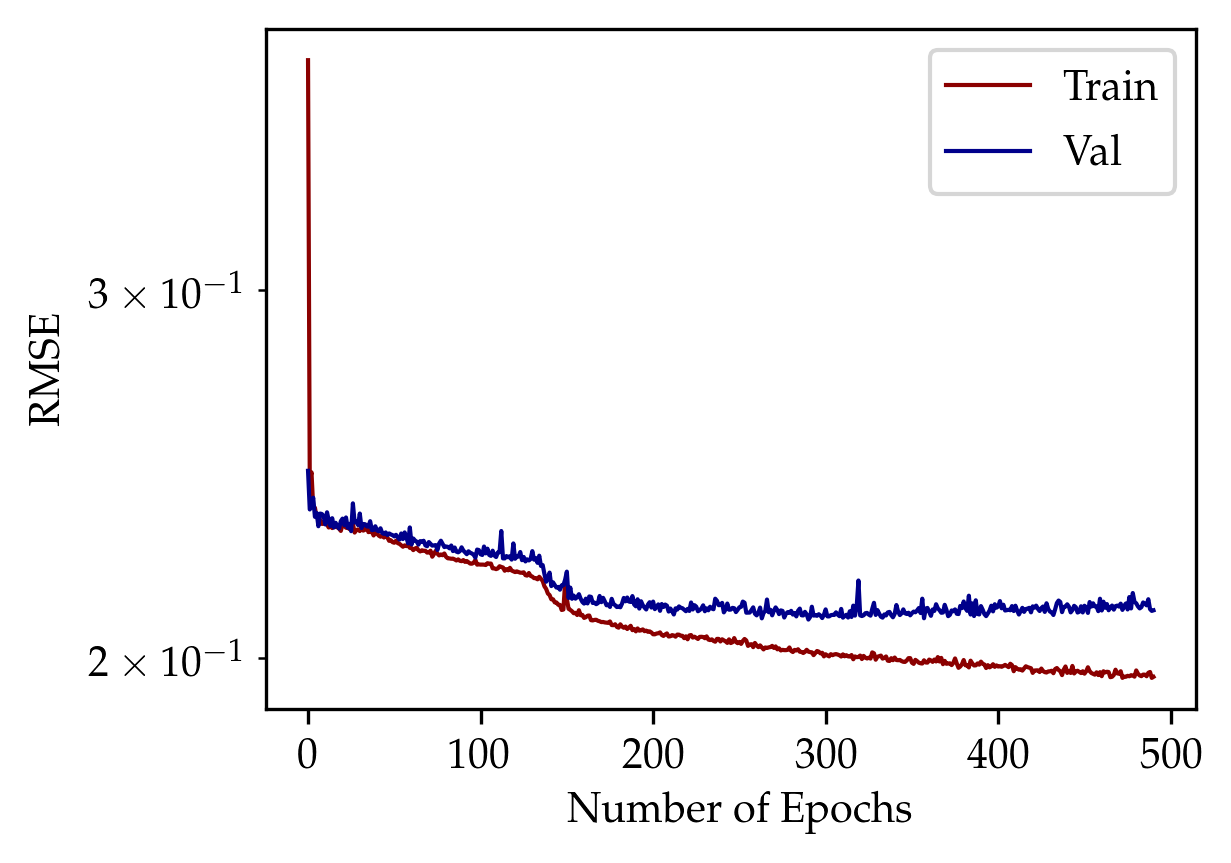

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(4,3), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(train_metrics.keys()):
    if key != 'mse':continue
    train_values = np.array(train_metrics[key])

#     train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
#     vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes.plot(train_values, label='Train', color='darkred', linewidth=1)
    axes.plot(vaild_values, label='Val', color='darkblue', linewidth=1)

    axes.set_ylabel('RMSE')
    if key != 'accuracy':
        axes.set_yscale('log')
axes.legend(loc='upper right')
fig.text(0.52, 0., 'Number of Epochs', ha='center')
fig.savefig('presentation/figures/ogle_20_lc.png', transparent=True, bbox_inches='tight')


## Finetuning

In [29]:
conf_file = os.path.join(conf['p'], 'finetuning', 'model', 'conf.json')
with open(conf_file, 'r') as handle:
    conf_ft = json.load(handle)
conf_ft

{'max_obs': 50,
 'data': './data/records/ogle/',
 'p': './runs/machito_0/finetuning/model',
 'batch_size': 256,
 'epochs': 10000,
 'patience': 200,
 'layers': 2,
 'heads': 4,
 'head_dim': 256,
 'dff': 128,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001,
 'use_leak': False,
 'no_train': False,
 'no_shuffle': False,
 'msk_frac': 0.5,
 'rnd_frac': 0.2,
 'same_frac': 0.2,
 'exp_date': '2021-09-02 23:53:57'}

In [30]:
test_batches_ft = pretraining_records(os.path.join(conf_ft['data'], 'test'), 
                            conf_ft['batch_size'], 
                            max_obs=conf_ft['max_obs'])

sum([1 for x in test_batches_ft.unbatch()])

5000

In [31]:
ft_model = get_ASTROMER(num_layers=conf_ft['layers'],
                        d_model=conf_ft['head_dim'],
                        num_heads=conf_ft['heads'],
                        dff=conf_ft['dff'],
                        base=conf_ft['base'],
                        dropout=conf_ft['dropout'],
                        maxlen=conf_ft['max_obs'])

In [32]:
weights_path = '{}/weights'.format(conf_ft['p'])
ft_model.load_weights(weights_path)

In [33]:
result = predict(ft_model, test_batches_ft, conf_ft)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['lcid', 'label', 'output', 'mask_out', 'mean', 'obserr'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 20it [00:01, 14.65it/s]


In [37]:
%%time

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

r2_masked = []
rmse_masked = []
for yt, yp, m in zip(result['x_true'], result['x_pred'], result['mask']):
    
    y_true_mask = tf.boolean_mask(yt[:, None], m)
    y_pred_mask = tf.boolean_mask(yp, m)

    r2_value = r2_score(y_true_mask, y_pred_mask)
    rmse = mean_squared_error(y_true_mask, y_pred_mask, squared=False)
    r2_masked.append(r2_value)
    rmse_masked.append(rmse)

CPU times: user 13.7 s, sys: 325 ms, total: 14.1 s
Wall time: 12.3 s


In [38]:
tf.reduce_mean(rmse_masked)

<tf.Tensor: shape=(), dtype=float32, numpy=0.055927336>

In [23]:
print('r2: {}\nmse: {}'.format(r2_score(result['x_true'][...,0], result['x_pred'][...,0]), result['mse']))

r2: 0.8137354836049578
mse: 0.0891951322555542


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


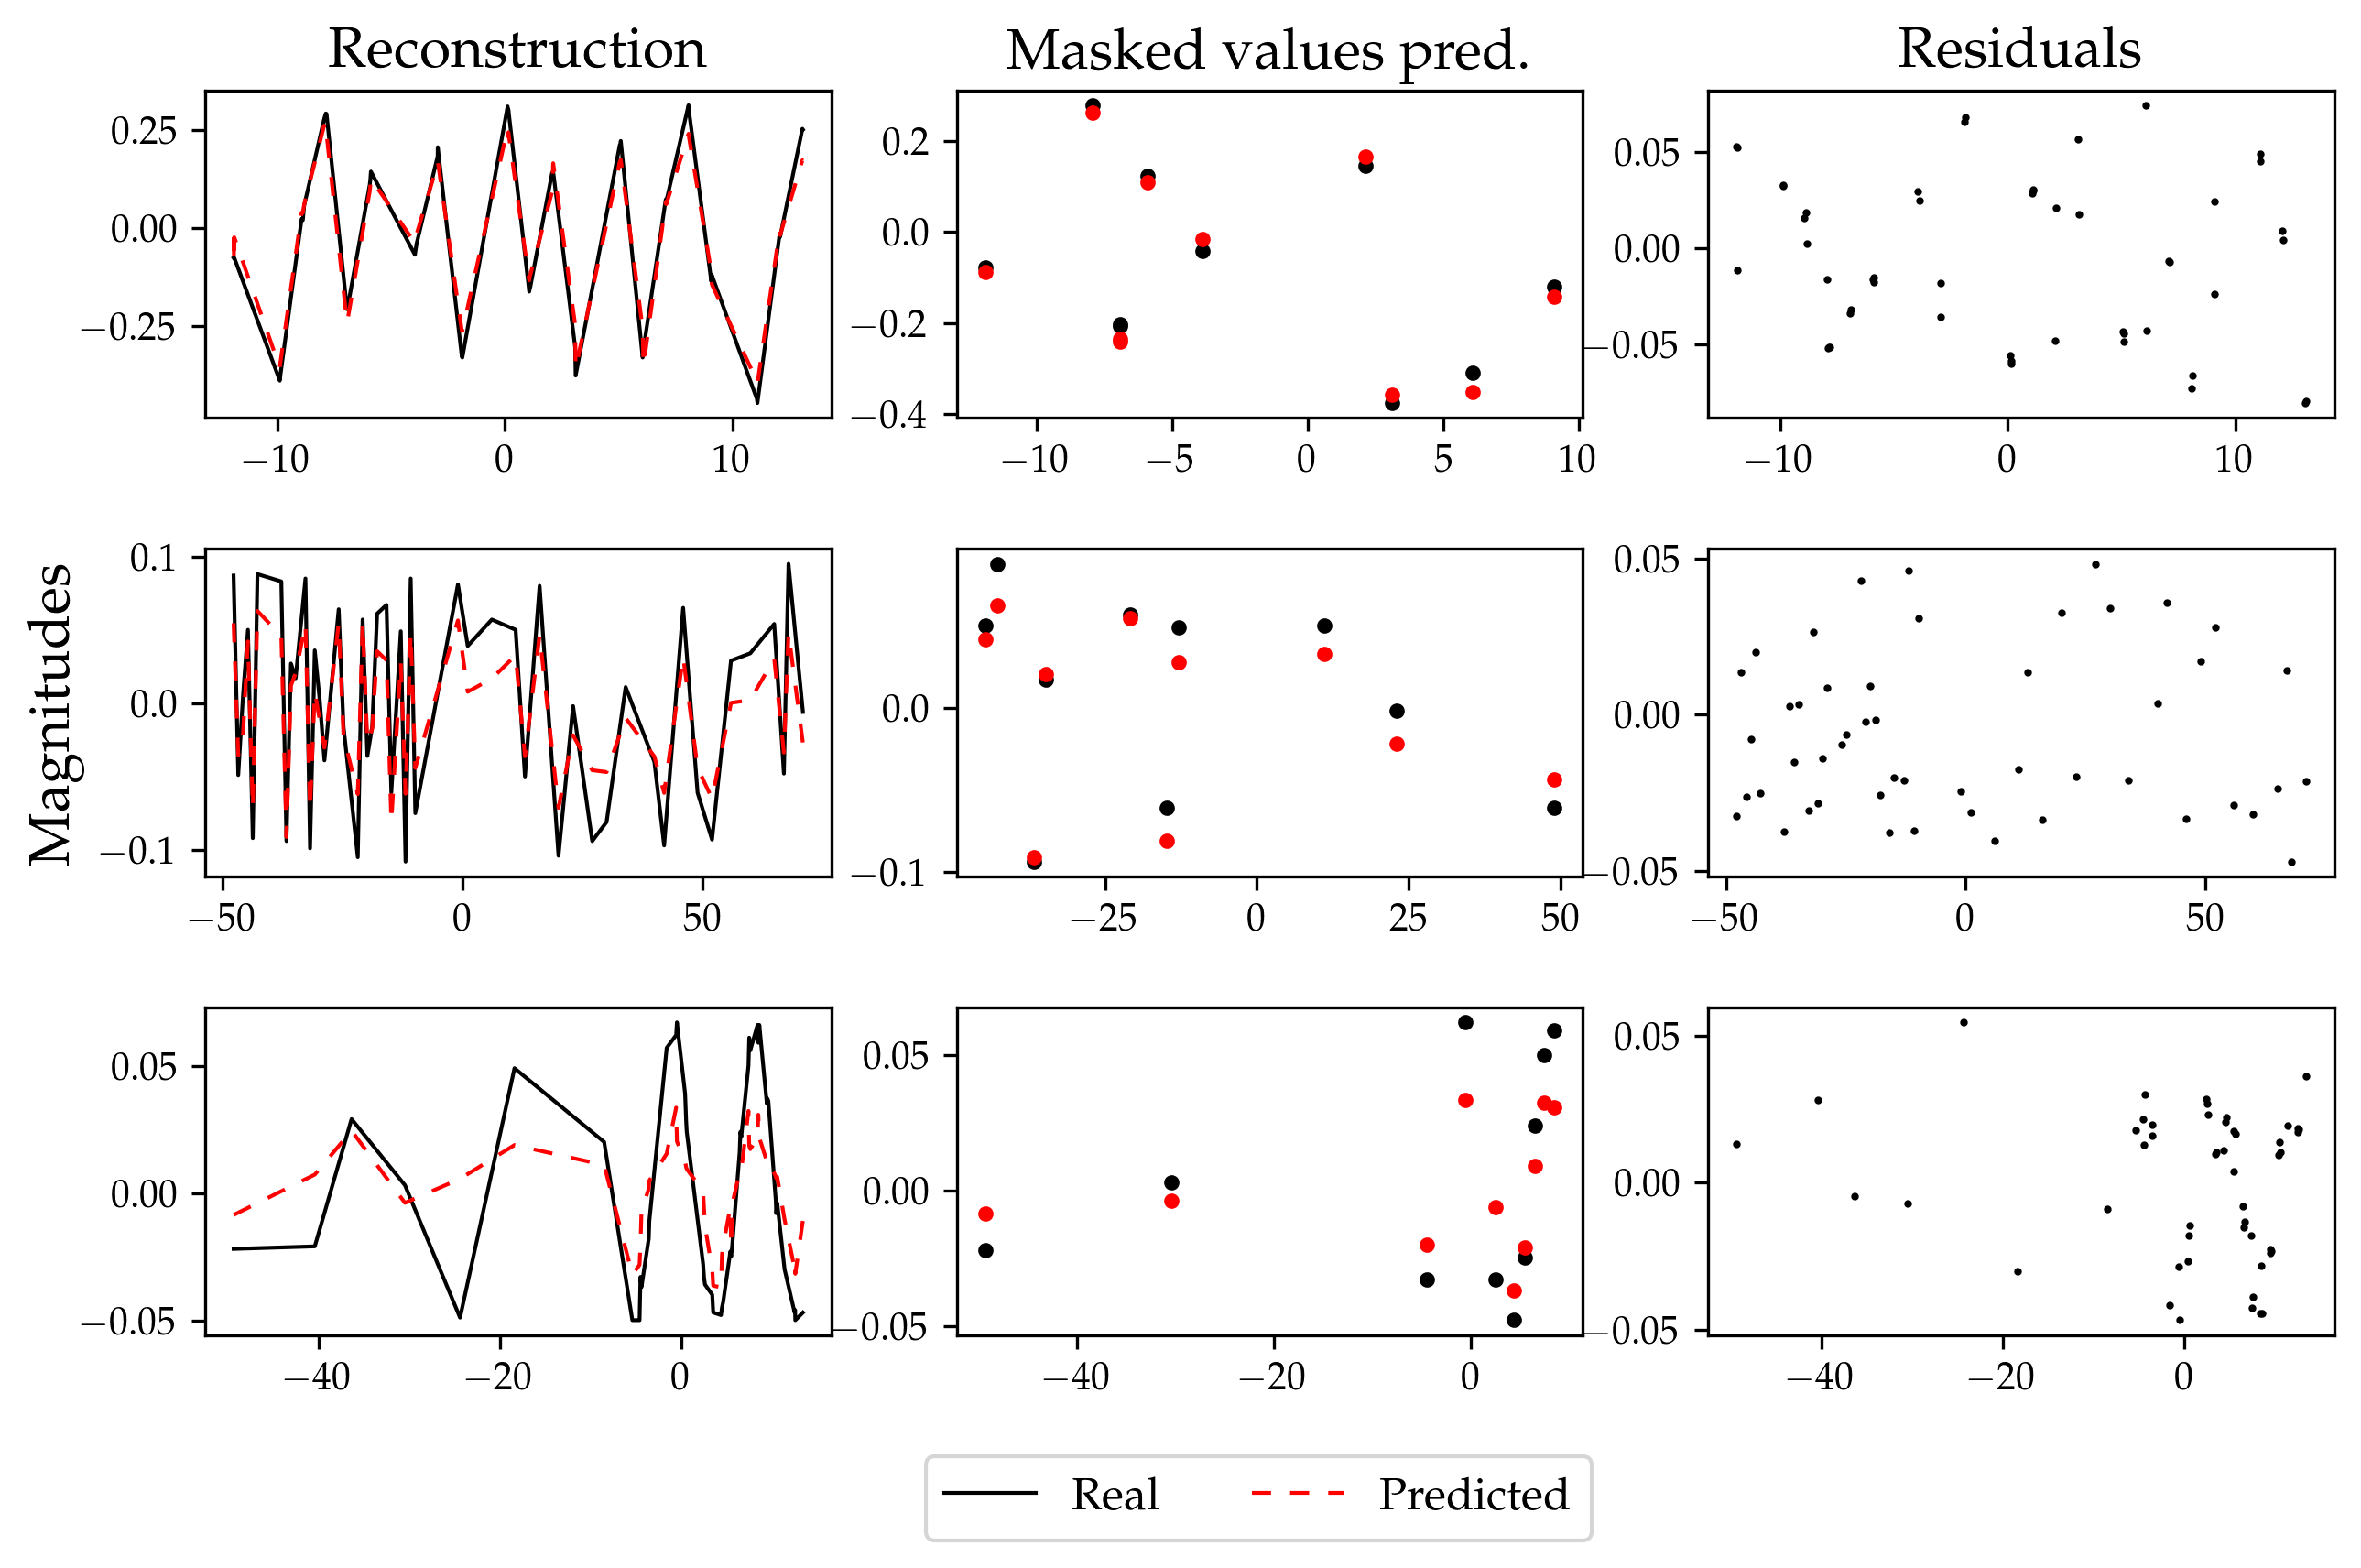

In [28]:
N = 3
fig, axes = plt.subplots(N, 3, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=False)

obs = conf['max_obs']//2

for i in range(N):

    times = result['time'][i]
    serie_pred = result['x_pred'][i]
    serie_true = result['x_true'][i]
    
    axes[i][0].plot(times, serie_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times, serie_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    
    if i == 1:
        axes[i][0].set_ylabel('Magnitudes', fontsize=15)
    
    
    true_mask = tf.boolean_mask(result['x_true'][i], result['mask'][i])
    pred_mask = tf.boolean_mask(result['x_pred'][i], result['mask'][i])
    time_mask = tf.boolean_mask(times, result['mask'][i])

    axes[i][1].plot(time_mask, true_mask, marker='.',linewidth=1, linestyle='', color='k', label='Real')
    axes[i][1].plot(time_mask, pred_mask, marker='.',linewidth=1, linestyle='', color='red', label='Predicted')

    # RESIDUALS
    residuals = serie_pred - serie_true
    axes[i][2].plot(times, residuals, '.', markersize=2, color='k')
    
    if i == 0:
        axes[i][2].set_title('Residuals', fontsize=15)
        axes[i][1].set_title('Masked values pred.', fontsize=15)
        axes[i][0].set_title('Reconstruction', fontsize=15)
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (2.25, -0.3), fontsize=12)
fig.tight_layout()
fig.savefig('presentation/figures/alock_result.png', transparent=True)

In [40]:
train_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'train'))
val_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'valid'))

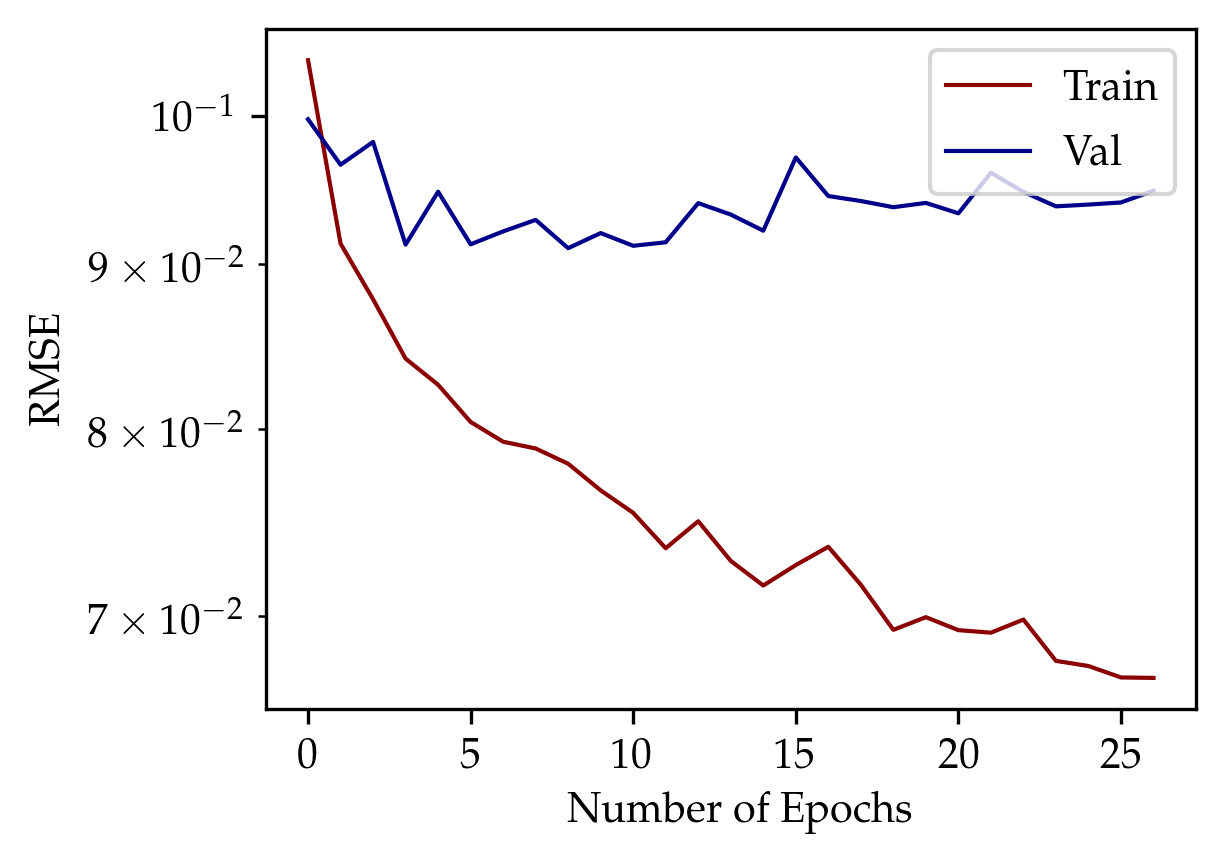

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(4,3), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes.plot(train_values, label='Train', color='darkred', linewidth=1)
    axes.plot(vaild_values, label='Val', color='darkblue', linewidth=1)
    axes.set_ylabel('RMSE')
    if key != 'accuracy':
        axes.set_yscale('log')
        
axes.legend(loc='upper right')
fig.text(0.52, 0.0, 'Number of Epochs', ha='center')


fig.savefig('presentation/figures/ogle_20_lc.png', transparent=True, bbox_inches='tight')

# Pred error vs Obs err

In [24]:
from core.astromer import valid_step
import seaborn as sns

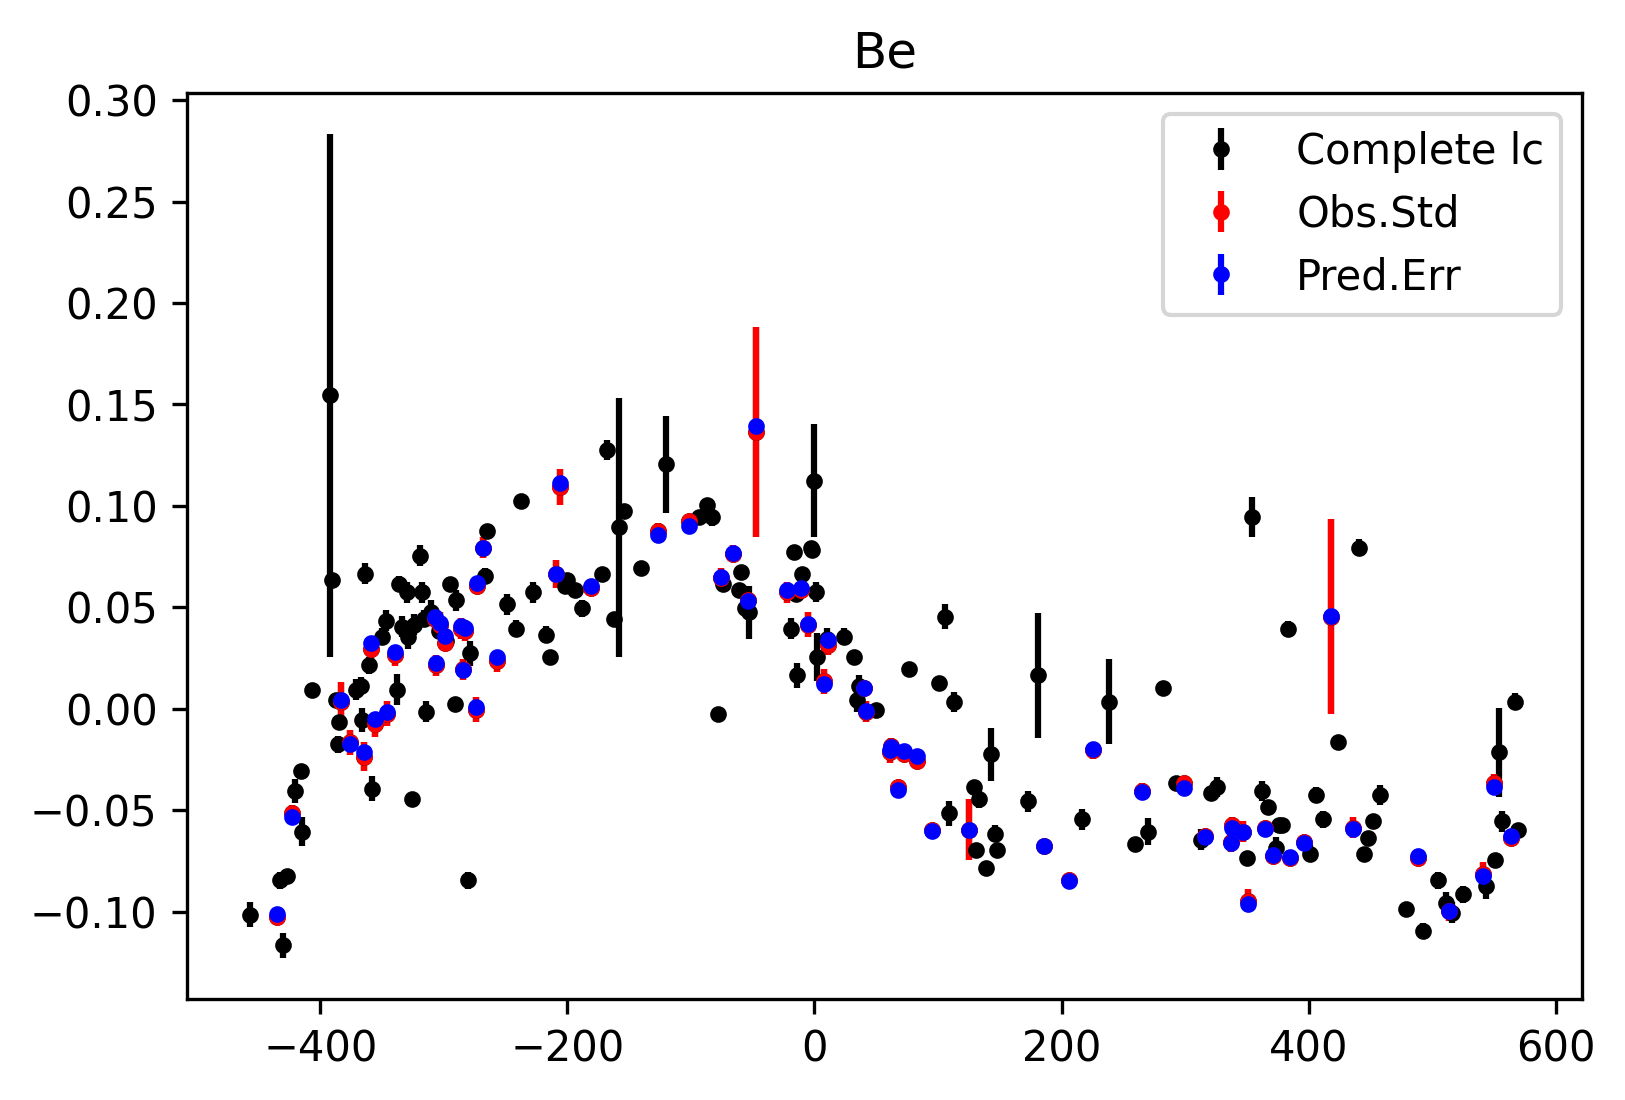

In [25]:
for step, batch in enumerate(test_batches):
    plt.figure(dpi=300)
    mse, x_pred, x_true = valid_step(astromer,
                                     batch,
                                     return_pred=True,
                                     normed=False)

    pred = x_pred[0]
    true = x_true[0]
    
    pred_err = true - pred
    
    errs = batch['obserr'][0]
    time = batch['times'][0]
    mask = batch['mask_in'][0]
    
    time = time[abs(errs)<200]
    mask = mask[abs(errs)<200]
    pred = pred[abs(errs)<200]
    true = true[abs(errs)<200]
    pred_err = pred_err[abs(errs)<200]
    errs = errs[abs(errs)<200]
    
    pred_masked = tf.boolean_mask(pred, mask)
    true_masked = tf.boolean_mask(true, mask)
    errs_masked = tf.boolean_mask(errs, mask)
    time_masked = tf.boolean_mask(time, mask)
    perr_masked = tf.boolean_mask(pred_err, mask)

    plt.errorbar(time, true, yerr=errs,
                 linestyle='', marker='.', color='k', label='Complete lc')
    
    plt.errorbar(time_masked, true_masked, yerr=errs_masked,
                 linestyle='', marker='.', color='r', label='Obs.Std')

    plt.errorbar(time_masked, pred_masked, yerr=perr_masked,
                 linestyle='', marker='.', color='b', label='Pred.Err')


    plt.legend()
    plt.title('{}'.format(class_names[batch['label'][0]]))
    break